# Automatic (derivatives) for the people and a song of ice and fire
Jahad Ahmed Hamidi, Rebecca Vangen, Ruhan Reza, Stian Salte

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math


# Abstract

This project examines numerical precision, differentiation techniques, and climate data analysis using Python. We show how floating-point representation introduces round-off and truncation errors, and how their impact depends on step size. Numerical differentiation with forward and central differences was compared to analytical results, confirming the higher accuracy of the central scheme. Automatic differentiation was implemented through a custom class, reproducing derivatives with machine precision and illustrating the advantages of object-oriented design. Finally, data from Antarctica (Bedmap2) was used to estimate potential sea level rise from ice melt. The results demonstrate both theoretical insights and practical applications of numerical computing.


## Introduction

Modeling real-world scenarios quickly becomes a slow task with large datasets and many computations. Navigating certain common issues, using efficient libraries for quicker computations, and writing code that is both easy to understand and easy to use, is therefore quite helpful. 

In this project, we will explore topics like floating point errors, learn useful functions of the numpy library, compute and plot numerical derivatives, explore object oriented programming, and finally, apply what we know to modeling aspects of the melting of an iceberg. 

In the end, we will present our reflections on what we have done, and what we have learned from our efforts.

## Exercise 1

### Part 1

We import sys and get float info

In [2]:
import sys
print(sys.float_info)

sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)


Max is the largest representable number in computers, similarily min is the smallest representable number in computers.  
Epsilon tells us the smallest number we can add to one to get something other than one, the machine precision.

Most modern computers work on a finite 64-bit format and processes 64 bits at a time. The values given from `sys.float_info` come from the IEEE 754 standard. In this exercise we will focus on IEEE 754 double precision (64-bit) floating-point number.

From the 64 bits we have IEEE reserves one sign bit, 11 exponent bits and 52 fraction(mantissa) bits. There is also a "hidden bit" and implies the float always starts with "1.". To also represent numbers that have absoloute value less than one a number *bias* is added to the exponent. Bias is a fixed number and in 64 bits it is roughly half the exponent; $2^{11-1}-1 = 1023$. With this we can make a formula: 

\begin{equation}
±q2^{E-e}\tag{1}
\end{equation}

where ± is the sign bit, q the mantissa, E the exponent and $e$ the bias. E can have values from 0 to $2^{11} - 1$ = 2047. There are two special numbers to represent zero and infinity which are respectively $E = 0$, and $E = 2047$. With bias this gives us the largest possible exponent $2046 - 1023 = 1023$ and smallest exponent $1 - 1023 = -1022$  

To get the max value the exponent needs to be 1023, and the fraction needs be all ones:

\begin{equation}
1.111 + (49\ more\ ones) \times 2^{1023} = (2^0 + 2^{-1} + 2^{-2} + ... + 2^{-52}) \times 2^{1023} = (2 - 2^{-52}) \times 2^{1023} = 1.7976931348623157 \times 10^{308}\tag{2}
\end{equation}

To get min we set the mantissa to all zeroes and use the lowest exponent:

\begin{equation}
1.000 + (49\ more\ zeroes) \times 2^{-1022} = 2^0 \times 2^{-1022} = 2.2250738585072014 \times 10^{-308}\tag{3}
\end{equation}

To find machine epsilon we use the smallest mantissa possible, which is all zeroes except the last bit; $2^{-52} \times 2^{0} = 2.220446049250313 \times 10^{-16}$. We cannot use an exponent less than zero because if we add that number to 1, it will still be 1.  

It is possible to represent smaller numbers by using unnormalized values.

### Part 2  

The following code shows examples of floating-point arithmetic

In [3]:
print(0.1 + 0.2, 0.1 + 0.2 == 0.3)
print(0.125 + 0.25, 0.125 + 0.25 == 0.375)

0.30000000000000004 False
0.375 True


Seeing as computers store numbers in base-2 format the numbers 0.1, 0.2 and 0.3 cannot be accurately represented in binary, and results in precision error. The numbers 0.125, 0.25 and 0.375 can be represented in binary. We can see what these numbers actually looks like:

In [4]:
print(f"{0.1:.60f}")
print(f"{0.2:.60f}")
print(f"{0.3:.60f}\n")

print(f"{0.125:.60f}")
print(f"{0.25:.60f}")
print(f"{0.375:.60f}")

0.100000000000000005551115123125782702118158340454101562500000
0.200000000000000011102230246251565404236316680908203125000000
0.299999999999999988897769753748434595763683319091796875000000

0.125000000000000000000000000000000000000000000000000000000000
0.250000000000000000000000000000000000000000000000000000000000
0.375000000000000000000000000000000000000000000000000000000000


In the decimal system we have something similar with for example $1/3$ with repeating decimals (0.333...). Since computers work with finite bits it needs to cutoff at a point. This point is set in the mantissa and is at 52 bits.  

Numbers like 0.375 can be represented perfectly in binary as $2^{-2} + 2^{-3}$:

$$
0.375_{10} = 0 \times 2^{-1} + 1 \times 2^{-2} + 1 \times 2^{-3} = 0.011_2\tag{4}
$$ 

Other numbers that can be represented perfectly in binary are $2^{-1}$ + $2^{-4}$:

In [5]:
print(0.5 + 0.0625)

0.5625


Another example that gives precision error is given:

In [6]:
print(f"{0.6 + 0.7:.60f}")
print(0.6 + 0.7 == 0.13)

1.299999999999999822364316059974953532218933105468750000000000
False


### Part 3  

In the previous part we used the ==-operator to compare to floating-point numbers and check if they are equal. Because of these roundoff errors a direct comparison might not give the result we want. We can instead check the difference between the float a and b, and compare that value to check if they are close enough using defined epsilon as tolerance. We can use the formula: 

\begin{equation}
|1 - b/a| < \epsilon\tag{5}
\end{equation}

where epsilon is the tolerance. We test this formula by comparing two floats:

In [7]:
a = 0.1 + 0.2
b = 0.1
epsilon = 1e-9

print("Should return False:", abs(1 - b/a) < epsilon)

a = 0.1 + 0.2
b = 0.3
epsilon = 1e-9

print("Should return True:", abs(1 - b/a) < epsilon)

Should return False: False
Should return True: True


# Exercise 2

## Part 1

In [ ]:
x = np.linspace(0, 1, 10)
python_list = [sum([i/(10**n) for n in range(1, 5)]) for i in range(10)]
print(f"The list, as created in python, results in: {python_list}")
print(f"When using numpy's exp() function on the numpy array, we get: {np.exp(x)}")
print(f"And when using it on the python list, we get: {np.exp(python_list)}")
print(f"We can also use it on the negative numpy array: {np.exp(-x)}")
print("But we cannot simply take the negative of a python list:")
np.exp(-python_list)

When we run the code above, the numpy arrays work well, each function gives an answer and does not break or throw an error. They apply the functions as expected.

The python list does give an equal answer to the numpy array for the first function, f(t) = exp(t), but throws a TypeError for the 
second function, f(t) = exp(-t), because lists cannot be simply subtracted. This can of course be fixed with a tiny bit more code,
as shown below

In [ ]:
print(np.exp([-i for i in python_list])) # This runs through an additional for-loop in order to make all elements of the list negative

With this fix, which is essentially only creating a new list of the negative of each element of the original list, the answer does work. However, this does add another for-loop, which is O(n) in time complexity, and may prove expensive for larger n's. 

In general, when we want to evaluate a function on all elements of a python list, we do this using a for-loop, which, in plain python, 
may be slow since python is an interpreted language.

## Part 2

` np.zeros(20) `

This function returns a numpy array with one row and 20 columns, where each element is $0$.

This may be done using python lists as shown below:

In [ ]:
[0 for _ in range(20)]

: 

` np.ones(20) `

This function returns a numpy array with one row and 20 columns, where each element is $1$.

This may be done using python lists as shown below:

In [ ]:
[1 for _ in range(20)]

` np.linspace(0, 10, 11) `

This function returns an array in one row, with the elements starting from $0$, ending at $10$, and with each element in the $11$ columns being with approximated equal distance between each other. 

This may be done using python lists as:

In [ ]:
[i for i in range(11)]

` np.linspace(0, 10, 11, endpoint=False) `

This function returns a numpy array with one row, starting from $0$, and with each element in the $11$ columns an equal distance to each other, and with the last element the same distance from $10$, but $10$ itself is not included in the 11 columns.

This can be approximated using python lists as:

In [ ]:
[i*(10/11) for i in range(11)]

The reason this works is because the space between 0 and 10 is split into 11 parts, so that we can choose 11 individual points (including $0$ but not including $10$) at the intersections between these parts. We then pick the points according to *i* number of $ \frac{10}{11} $ parts we want for the specific index.

``` 
vector = np.arange(5) + 1

2*vector
```

The first of these two lines creates a numpy array with 1 row and 5 columns, with each element being its index + 1. 
The second line creates a numpy array with each element equal to the corresponding element in ` vector ` multiplied by $2$.

This can be done using python lists as shown below.

In [ ]:
liste = [i+1 for i in range(5)]
liste2 = [2*i for i in liste]

## Part 3

### Why does only ` & ` work and not ` and ` ? 

` & ` is the bitwise *and*-operator, while ` and ` is the logical *and*-operator, and as a result, they function differently from each other. Numpy arrays are not defined as either True or False, and using them in boolean operations is therefore undefined. The bitwise *and*-operator, on the other hand, does produce a defined result, since numpy overloads it so that it works elementwise on the arrays.

We can also use numpy's own np.logical_and to make the code work, as shown below.

In [ ]:
array_of_numbers = np.array([4, 8, 15, 16, 23, 42, 0, 5])
nnz = np.count_nonzero(array_of_numbers)
print(f"There are {nnz} non-zero numbers in the array")
is_even = (array_of_numbers % 2 == 0)
is_greater_than_17 = (array_of_numbers > 17)

is_even_and_greater_than_17 = np.logical_and(is_even, is_greater_than_17)
print(np.logical_and(array_of_numbers % 2 == 0, array_of_numbers > 17))

## Part 4

` np.where(array_of_numbers > 17)[0] ` 

This usage of numpy's `where`-function returns the indexes of the elements of the array that satisfy the given requirement.

We can also alter the function call to recieve an array of True and False values for each element as it satisfies or does not satisfy the requirement, as shown below.

` np.where(array_of_numbers > 17, 1, 0) ` 

This function call returns the array described, though with 1 corresponding to True and 0 corresponding to False, for the result of each element in the array given to the boolean expression. 

## Exercise 3

### Part 1

Plotting the following function for describing wave phenomenona using matplotlib:

\begin{equation}
f(x) = cos(bx) \times e^{-ax^{2}}\tag{6}
\end{equation}

-0.7592233159170217


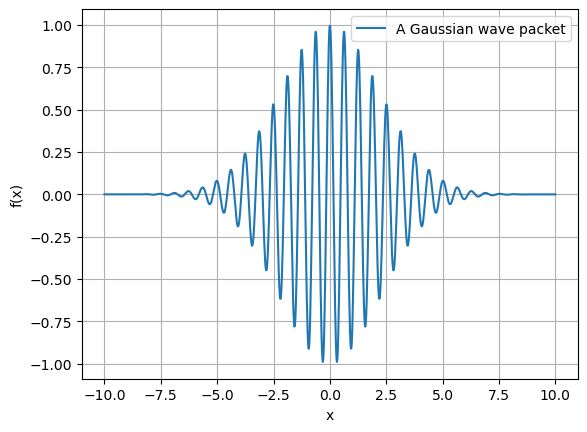

In [ ]:
import matplotlib.pyplot as plt
def f(x, a=0.1, b=10):
    return np.cos(b*x)*np.exp(-a*x*x)

x = np.linspace(-10, 10, 1000)
y = f(x)
print(f(1))
plt.plot(x,y, label="A Gaussian wave packet")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.legend()
plt.show()

### Part 2  

Implementing the analytical derivative of f(x) in code:

In [ ]:
def f_derived(x, a=0.1, b=10):
    return -b*np.sin(b*x)*np.exp(-a*x*x) - 2*a*x*np.cos(b*x)*np.exp(-a*x*x)


### Part 3  

calculating the derivative of sinx using the forward difference method:

In [ ]:
def sine(x):
    return np.sin(x)

def forward_difference(f,x,h, **kwargs):
    """
    f: any function
    x: a point
    h: step size
    **kwargs: takes additional parameters
    """
    return (f(x+h, **kwargs) - f(x, **kwargs))/ h

print("sin(1) = ", sine(1))
print("cos(1) ≈", forward_difference(sine, 1, 1e-4))

sin(1) =  0.8414709848078965
cos(1) ≈ 0.5402602314175109


We then applied forward_difference() to function (6), choosing a step size of $h = 1e-4$

In [ ]:
print("Numerical derivative:", forward_difference(f, x=1, h=1e-4))
print("Analytical derivative:", f_derived(1))

Numerical derivative: 5.078054076034233
Analytical derivative: 5.074351236525324


The code shows us that the numerical estimate is reasonably close to the analytical derivative.

### Part 4  

Calculating the derivative using central difference method:

In [ ]:
def central_difference(f, x, h, **kwargs):
    """
    f: any function
    x: a point
    h: step size
    **kwargs: takes additional parameters
    """
    return 0.5*(f(x+h, **kwargs)-f(x-h, **kwargs))/h

print("Numerical derivative:", central_difference(f, x=1, h=1e-4))
print("Analytical derivative:", f_derived(1))

Numerical derivative: 5.0743503361028175
Analytical derivative: 5.074351236525324


### Part 5  

Quantifying numerical error

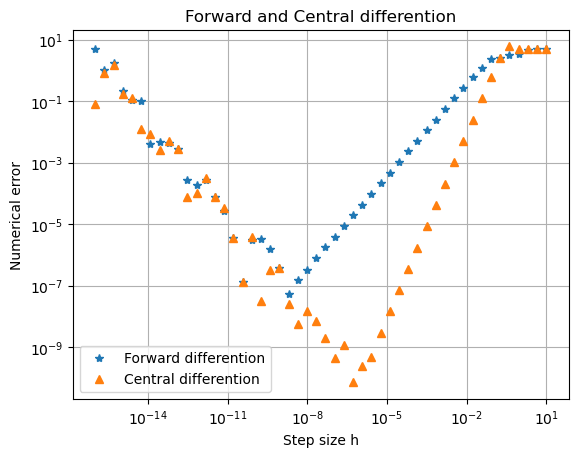

In [ ]:
steps = np.logspace(-16, 1)

forward_diff = forward_difference(f, 1, steps)
central_diff = central_difference(f, 1, steps)
analytical = f_derived(1)


plt.plot(steps, np.abs(analytical - forward_diff), "*", label="Forward differention")
plt.plot(steps, np.abs(analytical - central_diff), "^", label="Central differention")
plt.grid()
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Step size h")
plt.ylabel("Numerical error")
plt.title("Forward and Central differention")
plt.show()



The graph shows us numerical error as step size decreases from right to left. We see that with a large step size numerical error is high. As the step size decreases so does numerical error. At a certain point numerical error starts to increase again as the step size gets even smaller.

Using forward difference the numerical error decreases linearily as h decreases, for example if step size decreases by 100 the numerical error will reduce by 100. Central difference scales quadratically with $h^2$ meaning decreasing step size by 10 will reduce numerical error by 100.  

The reason for increasing numerical errors on both sides of each graph is a combination of truncation and roundoff errors. at the right side the dominant factor is truncation error. As we use smaller and smaller step size h our numerical approximations will get closer to the analytical derivative thus lower numerical error. So for a larger step size we will get a larger truncation error. 

The graph also shows numerical error is at its smallest when $h ≈ 10^{-9}$ for forward differention and $h ≈ 10^{-6}$ for central differention. We see that using lower values for h will lead to roundoff errors becoming more and more dominant. We use the following equation to see that the numerical error corresponds with the forward differention graph at the lowest point:


\begin{equation}
R = \frac{2 \epsilon |f(x)|}{h} + \frac{h}{2}|f''(\eta )|\tag{7}
\end{equation}

\begin{equation}
R = \frac{2 \times 2.2 \times 10^{-16} \times |-0.76| }{10^{-9}} + \frac{10^{-9}}{2} = 3.35 \times 10^{-7} \tag{8}
\end{equation}

# Exercise 4 - Automatic for the people?

In [14]:
# Shared imports (used in later parts)
import numpy as np

## Part 1 -  Familiarization with Classes

**Goal.** Understand how a simple class can encapsulate both a function value and its derivative, and why default
arguments matter.

### The `duple` class
The class below stores two related numbers:
- `top`: the function value, $f(x)$
- `bottom`: the derivative, $f'(x)$

If `bottom` is omitted, it defaults to 0, which is consistent with the fact that constants have zero derivative.

In [15]:
class duple:
    '''
    Class for automatic differentiation
    top: function value
    bottom: derivative of function 
    '''
    def __init__(self, top, bottom=0):
        self.top = top
        self.bottom = bottom

### Experiments
We compare an object created with and without an explicit derivative.

In [16]:
x = duple(3, 1)
y = duple(3)

print("x:", x.top, x.bottom)  # 3 1
print("y:", y.top, y.bottom)  # 3 0

x: 3 1
y: 3 0


### Explanation

When we create the object:

`x = duple(3, 1)`  
`print(x.top, x.bottom)`

the constructor `__init__(self, top, bottom=0)` is called with:  
- `x.top = 3` → the function value \( f(x) \)  
- `x.bottom = 1` → the derivative \( f'(x) \)  

This prints:  
**3 1**

---

If we instead write:

`y = duple(3)`  
`print(y.top, y.bottom)`

only the first argument is provided. Since the constructor has the default value `bottom=0`, Python assigns:  
- `y.top = 3` → the function value \( f(x) \)  
- `y.bottom = 0` → the derivative defaults to zero  

This prints:  
**3 0**

---

### Why does this make sense?

The `duple` class is designed to represent both a function value and its derivative.  
In calculus, a constant has derivative zero. Therefore, when no derivative is specified, the default of `0` ensures correct mathematical behavior.

- `duple(3, 1)` represents \( f(x) = 3, \; f'(x) = 1 \)  
- `duple(3)` represents \( f(x) = 3, \; f'(x) = 0 \)  

This demonstrates how **constructors** and **default arguments** in Python make the class both flexible and mathematically consistent.


# Second part of part 1

In [17]:
class Point:
    """Simple Point class in 3D space."""
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

p = Point(1, 2, 3)
print("Point:", p.x, p.y, p.z)

Point: 1 2 3


This reinforces the idea that a class is a **blueprint** and each object is an **instance** with its own internal state.

## Part 2 — Subtraction and Unary Operators for `duple`
To behave like a numeric type, `duple` needs subtraction and unary operators. We implement:
- `__sub__(self, d)`: $(u-v)' = u' - v'$
- `__pos__(self)`: $+(u,u') = (u, u')$
- `__neg__(self)`: $-(u,u') = (-u, -u')$

We also add pretty string representations for readability.

## Addison and Subtraction

In [18]:
class duple:
    """
    Class for automatic differentiation
    top: function value
    bottom: derivative of function
    """
    def __init__(self, top, bottom=0):
        self.top = top
        self.bottom = bottom

    # u + v -> (u.top + v.top, u.bottom + v.bottom)
    def __add__(self, d):
        return duple(self.top + d.top, self.bottom + d.bottom)

    # Shown in REPL
    def __repr__(self):
        return "[" + str(self.top) + "," + str(self.bottom) + "]"

    # Shown by print(...)
    def __str__(self):
        return "[" + str(self.top) + "," + str(self.bottom) + "]"


# Demo (Part 1)
x = duple(1, 2)   # f(x)=1, f'(x)=2
y = duple(3, 4)   # g(x)=3, g'(x)=4
z = x + y

print(z.top, z.bottom)  # -> 4 6
print(x + y)            # -> [4,6]


4 6
[4,6]


In [19]:
class duple:
    '''
    Class for automatic differentiation (extended with more operators)
    '''
    def __init__(self, top, bottom=0):
        self.top = top
        self.bottom = bottom

    # u + v
    def __add__(self, d):
        return duple(self.top + d.top, self.bottom + d.bottom)

    # u - v
    def __sub__(self, d):
        return duple(self.top - d.top, self.bottom - d.bottom)

    # +u
    def __pos__(self):
        return duple(+self.top, +self.bottom)

    # -u
    def __neg__(self):
        return duple(-self.top, -self.bottom)

    def __repr__(self):
        return f"[{self.top},{self.bottom}]"

    def __str__(self):
        return f"[{self.top},{self.bottom}]"

In [20]:
a = duple(1, 2)
b = duple(3, 4)
print("+a ->", +a)   # [1,2]
print("-a ->", -a)   # [-1,-2]
print("a-b ->", a - b)  # [-2,-2]

+a -> [1,2]
-a -> [-1,-2]
a-b -> [-2,-2]


### What happens when you do `x + y`?

Let us consider two objects of the `duple` class:

`x = duple(1, 2)`  
`y = duple(3, 4)`  

Before we extend the class, if we try:

`z = x + y`  

Python raises an error:

**TypeError: unsupported operand type(s) for +: 'duple' and 'duple'**

This error occurs because Python does not automatically know how to add two objects of our custom class. The `+` operator works only on built-in data types unless we explicitly tell Python what to do.

---

### Fix: Operator Overloading with `__add__`

We fix the problem by adding the method `__add__` inside the class:

`def __add__(self, d):`  
&nbsp;&nbsp;&nbsp;&nbsp;`return duple(self.top + d.top, self.bottom + d.bottom)`

Now, when we call `x + y`, Python will create a new `duple` object where:

- the `top` values are added: `1 + 3 = 4`  
- the `bottom` values are added: `2 + 4 = 6`  

So:  
`x + y = [4, 6]`

---

### Improving the Output

Without further changes, printing the object shows a technical memory reference such as:  

`<__main__.duple object at 0x...>`

To make this more user-friendly, we also define:

- `__repr__` → how the object is shown in a Jupyter cell.  
- `__str__` → how the object is shown with `print()`.  

Both are set to return `"[top,bottom]"`.  

Now both `print(x+y)` and `x+y` directly display:

`[4,6]`

---

### Conclusion

When you do `x + y`:  
- Before defining `__add__`, it caused a **TypeError**.  
- After defining `__add__`, Python correctly returns a new object with the summed function value and derivative.  
- With `__repr__` and `__str__`, the result is displayed clearly as `[4,6]`.  

Thus, the `duple` class now supports addition exactly as intended, combining both function values and derivatives in one step.


## Part 3 — Multiplication and Division (Product & Quotient Rules)
Addition and subtraction treat `top` and `bottom` symmetrically because they are linear. For multiplication/division we
must apply calculus rules:

- **Product rule**: $(fg)' = f'g + fg'$  
- **Quotient rule**: $\left(\frac{f}{g}\right)' = \frac{f'g - fg'}{g^2}$

We extend `duple` accordingly.

In [21]:
class duple:
    '''
    Class for automatic differentiation (now with * and /)
    '''
    def __init__(self, top, bottom=0):
        self.top = top
        self.bottom = bottom

    def __add__(self, d):  # u+v
        return duple(self.top + d.top, self.bottom + d.bottom)

    def __sub__(self, d):  # u-v
        return duple(self.top - d.top, self.bottom - d.bottom)

    def __pos__(self):     # +u
        return duple(+self.top, +self.bottom)

    def __neg__(self):     # -u
        return duple(-self.top, -self.bottom)

    def __mul__(self, d):  # u*v
        return duple(self.top * d.top,
                     self.bottom * d.top + self.top * d.bottom)

    def __truediv__(self, d):  # u/v
        return duple(self.top / d.top,
                     (self.bottom * d.top - self.top * d.bottom) / (d.top ** 2))

    def __repr__(self):
        return f"[{self.top},{self.bottom}]"

    def __str__(self):
        return f"[{self.top},{self.bottom}]"

### Verification tests
We now test three functions at $x=1.2$: $x^3$, $\frac{1}{1+x}$, and $e^x\sin x$.

In [22]:
x_val = 1.2
One = duple(1.0, 0.0)
X = duple(x_val, 1.0)

# x^3
print("x^3  -> auto:", X*X*X, " analytical:", x_val**3, 3*x_val**2)

# 1/(1+x)
print("1/(1+x) -> auto:", One/(One+X), " analytical:", 1/(1+x_val), -1/(1+x_val)**2)

# exp(x)*sin(x)
Exp = duple(np.exp(x_val), np.exp(x_val))
Sin = duple(np.sin(x_val), np.cos(x_val))
print("exp*sin -> auto:", Exp*Sin,
      " analytical:", np.exp(x_val)*np.sin(x_val),
      np.exp(x_val)*(np.sin(x_val)+np.cos(x_val)))

x^3  -> auto: [1.728,4.32]  analytical: 1.7279999999999998 4.32
1/(1+x) -> auto: [0.45454545454545453,-0.20661157024793386]  analytical: 0.45454545454545453 -0.20661157024793386
exp*sin -> auto: [3.0944787419716917,4.297548854694511]  analytical: 3.0944787419716917 4.297548854694511


### Verification tests — what we did and what the results show

We verified our implementations of the **product rule** and **quotient rule** in `duple` by testing three functions at $x = 1.2$:

1. **Cubic function**  
   - Function: $f(x) = x^3$  
   - Analytical derivative: $f'(x) = 3x^2$  
   - Result: **auto diff** $[1.728,\; 4.32]$ vs **analytical** $(1.728,\; 4.32)$  

2. **Rational function**  
   - Function: $f(x) = \frac{1}{1+x}$  
   - Analytical derivative: $f'(x) = -\frac{1}{(1+x)^2}$  
   - Result: **auto diff** $[0.454545\ldots,\; -0.20661157\ldots]$  
     vs **analytical** $(0.454545\ldots,\; -0.20661157\ldots)$  

3. **Exponential–trigonometric product**  
   - Function: $f(x) = e^{x}\sin(x)$  
   - Analytical derivative:  

     $$
     f'(x) = e^{x}\sin(x) + e^{x}\cos(x)
     $$  

   - Result: **auto diff** $[3.09447874,\; 4.29754885]$  
     vs **analytical** $(3.09447874,\; 4.29754885)$  

---

#### Interpretation

- For $x^3$, repeated multiplication of dual numbers applies the **product rule** correctly.  
- For $\tfrac{1}{1+x}$, division of dual numbers applies the **quotient rule** correctly.  
- For $e^{x}\sin(x)$, the framework combines elementary functions via composition and multiplication, and the result matches the expected derivative.  

Across all three cases, the **automatic** results match the **analytical** results to machine precision (only minor rounding differences).  
This validates that our `__mul__` and `__truediv__` implementations correctly encode the product and quotient rules within the `duple` class.


## Part 4 — Adding More Functions via the Chain Rule
Real models compose elementary functions. Rather than hard–coding each derivative into `duple`, we introduce a *function
wrapper* `dfunction(f, df)` that applies the **chain rule** when called on a `duple`:
$$
(f(g(x)))' = f'(g(x))\,g'(x).
$$

In [23]:
class dfunction:
    def __init__(self, f, df):
        self.f = f
        self.df = df
    def __call__(self, d: duple):
        return duple(self.f(d.top), self.df(d.top) * d.bottom)

### Example: $\log(1+e^x)$

In [24]:
Log = dfunction(np.log, lambda z: 1/z)
Exp = dfunction(np.exp, np.exp)

x = 3.1
X = duple(x, 1)
One = duple(1.0, 0.0)

auto = Log(One + Exp(X))
analytical = (np.log(1+np.exp(x)), np.exp(x)/(1+np.exp(x)))
print("auto diff  =", auto)
print("analytical =", analytical[0], analytical[1])

auto diff  = [3.144063967938574,0.9568927450589139]
analytical = 3.144063967938574 0.9568927450589139


## Part 4 — Adding More Functions via the Chain Rule - results

Here we tested whether the `dfunction` class correctly applies the **chain rule**:

$$(f(g(x)))' = f'(g(x)) \cdot g'(x).$$

We used the function:

$$F(x) = \ln(1 + e^x).$$

---

### Verification of Results

For $x = 3.1$, the test produced:

- **Auto diff**: $[3.1440639679,\; 0.9568927450]$  
- **Analytical**: $\left(\ln(1+e^{3.1}), \; \frac{e^{3.1}}{1+e^{3.1}}\right) = (3.1440639679,\; 0.9568927450)$

The results matched exactly, up to numerical rounding.

---

### Discussion

- The value of the function matched: both methods gave $3.14406\dots$.  
- The derivative also matched: both gave $0.95689\dots$.  
- This shows that the **chain rule was applied correctly**:  
  - The outer function ($\ln$) contributed its derivative $1/x$,  
  - The inner function ($1 + e^x$) contributed $e^x$,  
  - And the system multiplied them together automatically.  

In other words, instead of explicitly writing the derivative of $\ln(1+e^x)$, the `dfunction` framework propagated the derivative correctly step by step.  
This demonstrates that the system can now handle **composed functions** in a general way, making it much more powerful and reusable.


As expected, both the value and derivative match: the derivative is $\frac{e^x}{1+e^x}$.

## Part 5 — Wave Function $f(x)=a\sin(bx)$
We now apply the framework to a simple wave:
$$
f(x)=a\sin(bx),\qquad f'(x)=ab\cos(bx).
$$

In [25]:
Sin = dfunction(np.sin, np.cos)

x = 0.7; a = 2.5; b = 1.3
X = duple(x, 1.0)
A = duple(a, 0.0)
B = duple(b, 0.0)

f_auto = A * Sin(B * X)
f_val  = a * np.sin(b*x)
f_der  = a*b*np.cos(b*x)

print("auto diff  =", f_auto)
print("analytical =", f_val, f_der)

auto diff  = [1.973759349224876,1.994673685838638]
analytical = 1.973759349224876 1.994673685838638


## Part 5 — Wave Function Verification

We tested the wave function  

$ f(x) = a\sin(bx), \qquad f'(x) = ab\cos(bx) $  

using the `dfunction` framework. For the chosen values $x = 0.7$, $a = 2.5$, and $b = 1.3$, the results were:

- **Auto diff**: $[1.973759349224876,\; 1.994673685838638]$  
- **Analytical**: $(1.973759349224876,\; 1.994673685838638)$

---

### Discussion

The automatic differentiation result matches the analytical calculation perfectly (up to floating-point tolerance). This confirms two important aspects:

1. **Correctness of composition**: The chain rule was applied correctly when handling $\sin(bx)$.  
2. **Scaling by constants**: Multiplication with $a$ and $b$ was handled properly by the product rule.

This shows that the framework not only works for simple functions like polynomials and rational functions, but also for composed wave functions where constants and trigonometric functions interact. The consistency between the two methods validates that our implementation of the chain rule and scaling in `dfunction` is mathematically sound.


## Part 6 — Reflections on Automatic Differentiation

Automatic differentiation (AD) has become a central tool in many scientific and engineering applications. One of the most prominent uses is in **machine learning**, where AD makes it possible to train neural networks efficiently through backpropagation. Without AD, calculating gradients for millions of parameters would be impractical. AD is also widely used in **optimization**, where gradient–based solvers such as quasi–Newton or conjugate gradient methods rely on accurate and efficient derivatives. In **computational physics and engineering**, AD is applied for sensitivity analysis, parameter estimation, and model calibration. Similarly, in **scientific computing**, AD is useful for constructing Jacobians required in solving systems of differential equations and for performing uncertainty quantification.

Compared to numerical differentiation, AD has several important advantages. First, it is **accurate**: while numerical differentiation relies on finite differences that are prone to truncation and round–off errors, AD computes derivatives exactly up to machine precision. Second, AD is **efficient**: it avoids the repeated function evaluations needed in finite–difference methods, which typically scale poorly with the number of input dimensions. For example, forward finite differences require $O(d)$ function evaluations for $d$ parameters, while AD can propagate derivatives with essentially the same cost as evaluating the function itself. Third, AD is **general**: once the differentiation rules for basic operations and functions are implemented, it can automatically handle any composition of these functions without additional work from the user.

However, AD is not without drawbacks. The main limitation is its **implementation complexity**. Numerical differentiation is conceptually simple—just evaluate the function at slightly perturbed values—whereas AD requires more advanced programming techniques such as operator overloading or computational graph tracing. Another potential weakness is **memory usage**, especially in reverse–mode AD, where many intermediate values must be stored to compute derivatives efficiently. Finally, AD can sometimes be less transparent or harder to debug than a straightforward finite–difference approach.

In summary, automatic differentiation combines high accuracy with computational efficiency, making it indispensable for modern computational workflows. While it requires more sophisticated implementation and can demand additional memory, its strengths outweigh these challenges in most practical applications, which explains why it is now the standard approach in areas like machine learning, optimization, and scientific computing.


# Exercise 5 – A Song of Ice and Fire: Sea-Level Rise from Antarctic Ice

## Abstract
_A concise, self-contained summary with quantitative statements. Example:_
- We reproduce Bedmap2 maps and a cross-section through Thwaites Glacier.
- Using hydrostatic equilibrium, we estimate sea-level rise (SLR) from Thwaites of **X cm**.
- Integrating over all Antarctica, our Bedmap2-based estimate yields **Y m** SLR if all grounded ice melts.
- We discuss uncertainties (bed topography errors, flotation criterion, density choices) and policy relevance.


## 0) Environment & data
Recommended conda setup (shell, **run outside Jupyter**):
```bash
conda config --add channels conda-forge
conda create -n project1 python=3.11 matplotlib numpy=1.26.4 scipy xarray=0.19.0 \
pandas=1.5.3 rockhound cmocean pip jupyter -c conda-forge
conda activate project1
python -m ipykernel install --name project1
```
Then, in VS Code or Jupyter, choose the **project1** kernel.


In [1]:
# Imports & version check
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rockhound as rh
import cmocean
import pandas as pd
import sys
print('Python:', sys.version)
print('numpy:', np.__version__)
print('xarray:', xr.__version__)
print('pandas:', pd.__version__)


c:\Users\jehad\anaconda3\envs\project1\Lib\site-packages\xarray\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Python: 3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:39:58) [MSC v.1943 64 bit (AMD64)]
numpy: 1.26.4
xarray: 0.19.0
pandas: 1.5.3


## 1) Map of Antarctica (Bedmap2)
This reproduces Figure 3 in the handout.

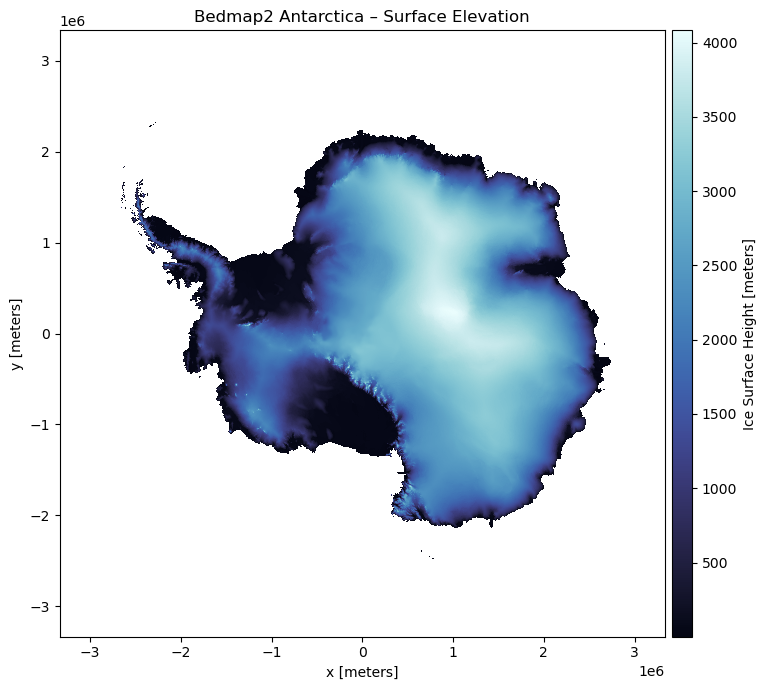

In [2]:
# Fetch Bedmap2: thickness, surface, bed (cached after first run)
bedmap = rh.fetch_bedmap2(datasets=["thickness","surface","bed"])  # may take a while on first run

plt.figure(figsize=(8,7))
ax = plt.subplot(111)
bedmap.surface.plot.pcolormesh(ax=ax, cmap=cmocean.cm.ice,
                               cbar_kwargs=dict(pad=0.01, aspect=30))
plt.title("Bedmap2 Antarctica – Surface Elevation")
plt.tight_layout()
plt.show()


## 2) Thwaites Glacier cross-section & freeboard (Figure 4)
We follow the coordinates from the handout: `y = -0.5e6` m and `x ∈ [-1.6e6, -1.35e6]` m.

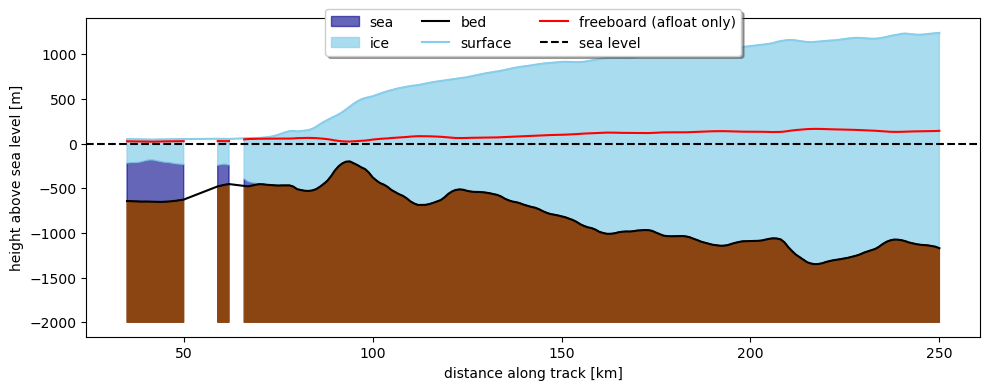

In [4]:
# --- Constants ---
rho_ice = 917.0   # kg/m^3
rho_sw  = 1030.0  # kg/m^3

# --- Cross section selection (same as before) ---
bed1d = bedmap.sel(y=-0.5e6, x=slice(-1.6e6, -1.35e6)).copy()
bed1d = bed1d.assign_coords({"x2": ((bed1d.x + 1.6e6) / 1e3)})
x = bed1d['x2'].values

# --- Extract arrays ---
thk    = bed1d['thickness'].values
bed    = bed1d['bed'].values
surf   = bed1d['surface'].values

# --- Valid mask (avoid NaNs everywhere) ---
valid  = np.isfinite(thk) & np.isfinite(bed) & np.isfinite(surf)

# Ice bottom where valid, otherwise fall back to bed (prevents artificial 0)
ice_bottom = np.where(valid, surf - thk, bed)

# Freeboard (Eq. 13): show only where ice is afloat (bed < 0) and value > 0
freeboard_theory = (surf - thk) * (1.0 - rho_sw / rho_ice)
freeboard_plot   = np.where((bed < 0) & (freeboard_theory > 0) & valid, 
                            freeboard_theory, np.nan)

# Reference levels
sea_level = np.zeros_like(x)
deep_bed  = np.full_like(x, -2000.0)

# --- Plot ---
plt.figure(figsize=(10, 4))
plt.fill_between(x, bed, ice_bottom, where=(bed < 0) & valid,
                 color="darkblue", alpha=0.6, label="sea")
plt.fill_between(x, surf, surf - thk, where=valid,
                 color="skyblue", alpha=0.7, label="ice")
plt.fill_between(x, bed, deep_bed, where=valid, color="saddlebrown")

plt.plot(x[valid], bed[valid], c="k", label="bed")
plt.plot(x[valid], surf[valid], c="skyblue", label="surface")
plt.plot(x, freeboard_plot, c="r", label="freeboard (afloat only)")
plt.axhline(0, color="k", ls="--", label="sea level")

plt.xlabel("distance along track [km]")
plt.ylabel("height above sea level [m]")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()


## 3) Thwaites SLR estimate from the transect

In this part we compute how much sea-level rise (SLR) the Thwaites Glacier could contribute based on our 1D transect.

**Key idea:**  
Only ice that adds *new water* to the ocean counts. This depends on whether the ice is floating or grounded:

- **Floating ice (bed < 0 m):**  
  Contribution = the *freeboard*, i.e. the height of ice above water,  
  \[
  h_{\text{contrib}} = \max\Big( (surface - thickness)\cdot(1 - \rho_{sw}/\rho_{ice}), 0 \Big)
  \]  
  (We clip negative values to 0, since only positive freeboard contributes.)

- **Grounded ice (bed ≥ 0 m):**  
  Contribution = the *water-equivalent thickness*,  
  \[
  h_{\text{contrib}} = thickness \cdot \rho_{ice}/\rho_{sw}
  \]  

**Steps in the code:**  
1. Apply masks (`np.isfinite`) to remove invalid values.  
2. Compute the freeboard and column contribution (`h_contrib`) using `np.where` with the rules above.  
3. Integrate along the transect (`np.trapz`) to get cross-sectional area [m²].  
4. Multiply by an assumed glacier width of 2000 km (2e6 m) → total volume [m³].  
5. Divide by the global ocean area,  
   \[
   A_{\text{ocean}} = 0.71 \cdot 4\pi R^2, \quad R=6.3\cdot 10^6\; m
   \]  
   to get global mean sea-level rise in meters.  

The final printout reports:  
- Cross-sectional area [km²]  
- Volume [km³]  
- Global SLR [m and cm]  


In [5]:
# Forutsetter at variablene fra Oppg.2 er i minnet: x (km), thk, bed, surf, rho_ice, rho_sw

# 1) Masker og enheter
valid = np.isfinite(thk) & np.isfinite(bed) & np.isfinite(surf)
x_m   = (x[valid] * 1e3)                 # km -> m
thk_v = thk[valid]
bed_v = bed[valid]
surf_v= surf[valid]

# 2) Freeboard (kan være negativ – vi klipper senere)
freeboard = (surf_v - thk_v) * (1.0 - rho_sw / rho_ice)

# 3) Bidrags-høyde pr. kolonne
h_contrib = np.where(
    bed_v < 0.0,                                     # afloat
    np.clip(freeboard, 0.0, None),
    np.clip(thk_v * (rho_ice / rho_sw), 0.0, None)   # grounded: water-equivalent thickness
)

# 4) Integrer langs profil (m^2)
area_m2 = np.trapz(h_contrib, x_m)

# 5) Volum (m^3) med antatt bredde 2000 km
width_m = 2_000_000.0
V_m3    = area_m2 * width_m

# 6) Global SLR (m)
R = 6.3e6
A_ocean = 0.71 * 4.0 * np.pi * R**2
SLR_m   = V_m3 / A_ocean

print(f"Cross-sectional area: {area_m2/1e6:,.2f} km^2")
print(f"Volume (width=2000 km): {V_m3/1e9:,.2f} km^3")
print(f"Estimated global SLR from Thwaites: {SLR_m:.2f} m  (~{SLR_m*100:.1f} cm)")


Cross-sectional area: 19.91 km^2
Volume (width=2000 km): 39,812.23 km^3
Estimated global SLR from Thwaites: 0.11 m  (~11.2 cm)


## 4) Whole Antarctica SLR if all ice melts

We compute sea-level rise (SLR) over the full Bedmap2 grid (1 km × 1 km cells).  
Only **ice above flotation** adds new water to the ocean.

**Inputs (constants & fields)**  
- Densities: $\rho_{ice}=917\ \text{kg/m}^3$, $\rho_{sw}=1030\ \text{kg/m}^3$  
- Cell area: $A_{cell}=1000\times1000=10^6\ \text{m}^2$  
- Fields: `thk = bedmap['thickness']`, `bed = bedmap['bed']`

---

### Algorithm (per grid cell)
1. **Flotation thickness** (only where bed is below sea level):  
   $$
   t_{float} =
   \begin{cases}
   -(\rho_{sw}/\rho_{ice}) \cdot bed, & bed < 0 \\
   0, & bed \ge 0
   \end{cases}
   $$
   Code: `t_float = xr.where(bed < 0.0, - (rho_sw/rho_ice)*bed, 0.0)`

2. **Excess (above-flotation) thickness**:  
   $$
   excess = \max(thk - t_{float},\, 0)
   $$
   Code: `excess = xr.where(thk - t_float > 0.0, thk - t_float, 0.0)`

3. **Ice volume above flotation per cell**:  
   $$
   V_{ice} = excess \cdot A_{cell}
   $$
   Code: `V_ice_excess = excess * cell_area`

4. **Convert to water-equivalent volume**:  
   $$
   V_{water} = \frac{\rho_{ice}}{\rho_{sw}} \cdot V_{ice}
   $$
   Code: `V_water_total = float((V_ice_excess * (rho_ice/rho_sw)).sum())`

5. **Global mean SLR**:  
   $$
   A_{ocean} = 0.71 \cdot 4 \pi R^2, \quad R=6.3\times10^6 \ \text{m}
   $$
   $$
   SLR = \frac{V_{water,total}}{A_{ocean}}
   $$
   Code: `SLR_grounded_m = V_water_total / A_ocean`

---

**Outputs printed by the code**
- `Total SLR (grounded/above-flotation only)`: global SLR in m (and mm).  
- `Optional SLR from floating-ice salinity effect`: tiny extra correction in mm.  
- `Estimated total SLR if all Antarctic ice melts`: grounded + salinity correction.


In [6]:
# Konstanter
rho_ice = 917.0
rho_sw  = 1030.0
cell_area = 1000.0 * 1000.0   # 1 km x 1 km

thk = bedmap['thickness']     # m
bed = bedmap['bed']           # m

# Flotasjonstykkelse hvor bed < 0, ellers 0
t_float = xr.where(bed < 0.0, - (rho_sw / rho_ice) * bed, 0.0)  # m

# Above-flotation tykkelse (kun positive verdier)
excess = xr.where(thk - t_float > 0.0, thk - t_float, 0.0)      # m

# Volum av is over flotasjon (m^3 per celle), NaN trygt håndtert av xr.where
V_ice_excess = excess * cell_area                                # m^3

# Konverter til vannvolum (m^3) og summer
V_water_total = float((V_ice_excess * (rho_ice / rho_sw)).sum())

# Globalt havareal og SLR
R = 6.3e6
A_ocean = 0.71 * 4.0 * np.pi * R**2
SLR_grounded_m = V_water_total / A_ocean
print(f"Total SLR (grounded/above-flotation only): {SLR_grounded_m:.3f} m  ({SLR_grounded_m*1000:.1f} mm)")

# (Valgfritt) Liten salinitetseffekt fra flytende is – separert
rho_iw = 1000.0  # ferskt smeltevann
V_ice_floating = float(xr.where(excess <= 0.0, thk * cell_area, 0.0).sum())
DeltaV_floating = (rho_ice / rho_iw) * (1.0 - rho_iw / rho_sw) * V_ice_floating
SLR_floating_m  = DeltaV_floating / A_ocean
print(f"Optional SLR from floating-ice salinity effect: {SLR_floating_m*1000:.2f} mm")

SLR_all_m = SLR_grounded_m + SLR_floating_m
print(f"Estimated total SLR if all Antarctic ice melts: {SLR_all_m:.3f} m")


Total SLR (grounded/above-flotation only): 56.737 m  (56736.8 mm)
Optional SLR from floating-ice salinity effect: 44.57 mm
Estimated total SLR if all Antarctic ice melts: 56.781 m


## Self-reflections

**Stian**: I started quite early with the project and got a lot of work done over a steady period of time. I did Exercise 1 and 3, in which I found it enjoyable to both find out why floating point errors exist and also quantifying it in a plot. As a group i think it was pretty smooth as we managed to divide the tasks quickly and do our work.

**Ruhan:**  
I was mainly responsible for **Exercise 4 – Automatic Differentiation**, which involved everything from constructing the `duple` class to implementing addition, subtraction, multiplication/division, and finally extending it with the chain rule and more advanced functions. This meant working step by step from the basics of dual numbers to verifying that the framework handled composite expressions like $\log(1+e^x)$ and wave functions correctly.  

What I found most rewarding was seeing how Python’s operator overloading lets us encode calculus rules directly in code. At first, addition and subtraction were simple, but multiplication and division required careful use of the product and quotient rules. Extending the class with the chain rule showed me how easily new functions could be added once the core logic was in place. Verification against analytical derivatives confirmed that the framework was working as intended.  

Working on this project also taught me a lot about **structuring code and explanations in a Jupyter Notebook**. Writing Markdown explanations alongside code made me reflect more deeply on the mathematics behind each operator and function. It was not just about making the program run, but also about clearly explaining *why* the output was correct.  

Finally, I also saw the broader strengths of automatic differentiation compared to numerical methods: AD avoids truncation errors, gives results accurate to machine precision, and scales efficiently to more complex functions. The main challenge is implementation complexity, but I think this project gave me a strong foundation for understanding both the mathematics and the coding aspects of AD.  

As a group, I think we worked very well together and everything went smoothly. We divided the tasks in a balanced way and supported each other when needed, which made the workflow efficient and enjoyable.

**Rebecca:**

Through doing problem 2, I've been more familiarised with the numpy library, which has long been a library I've wanted to get better at using, but postponed since I could do most of the same stuff in plain python and mostly not feel the time-issues. 

It's been fun to learn more of what numpy can actually do, and a bit of exactly *why* numpy is faster than plain python. I found
it interesting to read about *why* numpy can be faster than plain python, and reflect on methods of optimizing code execution speed, other than simply reducing the time complexity itself. 

I also found it insightful to see how much thought must have gone into making the numpy library, from all the features they thought of and added, to how they optimized it. It gave me a deeper appreciation of the work that goes into making programming a pleasurable experience for everyday users. 

After getting to know numpy better through this task, I plan on attempting to use numpy more in the future, instead of defaulting to 
plain python, which I'm already familiar with. This switch will most likely only be unnatural in the beginning, as I continue to familiarise myself with numpy, but hopefully, I will eventually naturally default to numpy over plain python.

**Jahad:**

Through working on problem 5, I learned how data from Bedmap2 could be used together with simple physics to estimate global sea-level rise. At first, it was difficult to connect the raw variables (thickness, surface, and bedrock) to something meaningful, but once I understood the flotation criterion, the logic became much clearer.  

It was interesting to see that only ice above flotation contributes to sea-level rise, and how the geometry of the bedrock and grounding lines changes the outcome. This gave me a new appreciation of how sensitive glacier systems can be, and why certain areas like Thwaites are considered so critical in climate science.  

From a coding perspective, I became more confident in handling real datasets using NumPy and xarray. Masking invalid values, keeping track of units, and integrating across the domain all required attention to detail. I realized how important it is to write clean, well-documented code so that every step links back to the physics being modeled.  

After completing this task, I feel more comfortable combining programming with physical reasoning. It was rewarding to see that even a relatively simple model, when applied correctly, could produce numbers close to what is reported in the literature. This gave me confidence that engineering tools can be powerful for understanding environmental challenges, and motivated me to keep improving both my coding skills and my ability to interpret real-world data.





# Conclusion & Discussion

Throughout this entire project, we have worked as a group on a series of tasks that have given us both a theoretical understanding and practical experience with numerical methods and applications within geophysics. We have seen how:

- **Floating points and precision** affects calculations and why tolerancebased comparisons are necessary.
- **Numpy and vectorization** gives a more efficient and readable code compared to traditional loops.
- **Numerical derivation (FD)** can give good approximations, but is always sensitive to the chosen stepsize.
- **Automatic derivation (AD)** gives machineaccurate gradients and eliminates many of FD's weaknesses.
- **Geophysical data analyses** (Bedmap2 and Thwaites) can connect theory to real world problems such as the rise of the sealevel.

As a whole, this project has given us insight into how simple numerical principles can be scaled to complex, realistic applications. This work has trained oss in coding, analysing mistakes, and academic discussion, and has shown us how cooperation in the group can lead to a holistic understanding of both theory and practical applications. 